# DSFB Assignment 5

In this assignment, you will classify images from the MNIST dataset (Source: http://yann.lecun.com/exdb/mnist/). The dataset includes hand written images and you need to predict the number (numerical digit) associated with each image. Every image has a dimension of 28 * 28 pixels and is gray-scale. The input data includes the intensity associated with each pixel row by row, starting from top-left corner (784 pixels in total). 

The label field shows the number associated with each image. 

A state-of-the-art model achieves an error rate of only 0.23% (Ciresan et al. CVPR 2012); you should be able to hit an error rate of less than 1% in this assignment. 

<img src="http://corochann.com/wp-content/uploads/2017/02/mnist_plot.png" width="700" height="500" align="center"/>


Image source: http://corochann.com/wp-content/uploads/2017/02/mnist_plot.png

## SETUP

### Imports

Note that this assignment requires Tensorflow version 2. It must be version 2, as the Keras model in Tensorflow changed as of version 2. You can tensorflow with this pip command:

    pip install -U tensorflow


In [2]:
# Standard imports
import pandas as pd
import numpy as np
import itertools

# Data science packages
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics         import confusion_matrix
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression

# Neural networks
import tensorflow as tf

# Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

%matplotlib inline

### Constant Seed

In [3]:
# Set constant SEED for probabilistic functions for replicability
SEED = 12345

### Custom Functions

We again give you a few, custom, helper functions to get you going.

In [4]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.grid()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [5]:
def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

In [6]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False):
    
    plt.title('Validation Curve')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean    = np.mean(cv_scores,    axis=1)
    
    if x_logscale:
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean,    'o-', color="g",  label="Cross-validation score")        
    else:
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean,    'o-', color="g", label="Cross-validation score")
        
    plt.legend(loc='center')
    plt.show()

# PART 1: Preparation

**PROBLEM**: Load the image data into a pandas dataset. 

In [7]:
# Load data into a dataframe
data = pd.read_csv('data/image_data.csv')


In [8]:
# View the top rows
data.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**PROBLEM**: Check the data. Is it complete? Right shape? Any problems or inconsistencies?

In [9]:
data.shape
# The length is correct (785 - 1 "label" ) = 28*28

(42000, 785)

In [10]:
data["pixel300"].sample(n=10)
# The intensity is from 0 to 256

30408      0
12255      0
9372     253
7560       9
24779      0
37604      0
19329    252
31575      0
32967      0
9761       0
Name: pixel300, dtype: int64

In [11]:
data.isnull().values.any()
# There is no missing values

False

**PROBLEM**: Separate data into target variable and features.

In [12]:
# Separate features and target
y = np.array(data['label'])

features = data.columns
features = features[1:]
X = data.loc[:, features]


**PROBLEM**: Basic Feature Engineering.

In [13]:
# Normalize all features to be between 0 and 1
def normalize(value):
    return value/256

for feature in features:
    X[feature] = X[feature].apply(normalize)

X["pixel300"].sample(n=10)

32639    0.988281
41907    0.000000
39879    0.000000
13274    0.000000
39318    0.000000
36028    0.738281
7855     0.425781
37381    0.000000
7564     0.984375
33642    0.000000
Name: pixel300, dtype: float64

**PROBLEM**: Inspect distribution of target.

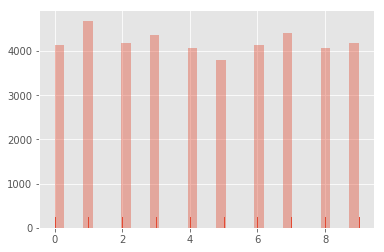

In [14]:
# Check distribution of the labels (across numerical digits)
sns.distplot(y, kde=False, rug=True);

**PROBLEM**: Plot images 27, 83, and 158 in ONE dimension.  

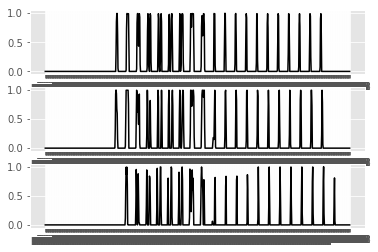

In [15]:
# Plot images 27, 83, and 158 in one dimension
plt.subplot(3, 1, 1)
plt.plot(X.iloc[27], color='black')

plt.subplot(3, 1, 2)
plt.plot(X.iloc[83], color='black')

plt.subplot(3, 1, 3)
plt.plot(X.iloc[158], color='black')

plt.show()


**PROBLEM**: Plot images 27, 83, and 158 in TWO dimensions. Tip: use `plt.imshow()`

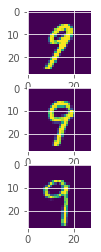

In [16]:
# Plot images 27, 83, and 158 in TWO dimension

def transform_2D(vector):
    Matrix = [[0 for x in range(28)] for y in range(28)] 
    for i in range(28):
        for j in range(28):
            Matrix[i][j] = vector[28*i + j] 
    return Matrix


image_27 =  transform_2D(X.iloc[27])
image_83 =  transform_2D(X.iloc[83])
image_158 =  transform_2D(X.iloc[158])

plt.subplot(3, 1, 1)
plt.imshow(image_27)

plt.subplot(3, 1, 2)
plt.imshow(image_83)

plt.subplot(3, 1, 3)
plt.imshow(image_158)

plt.show()


**PROBLEM**: Create Training and Testing sets. Be sure to use SEED so our results and your results are comparable. 

In [20]:
# Create Training and Testing sets -- complete the line of code
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

## Baseline Classifier

Before getting started on specific models, run a baseline classifier to set a benchmark for improved models.

**PROBLEM**: Use the `DummyClassifier()` model to make a baseline prediction.

In [21]:
# Define a baseline using DummyClassifier() and print the baseline accuracy. Remember to set the SEED!
from sklearn.metrics import accuracy_score
dummy = DummyClassifier().fit(X_train, y_train)
y_hat = dummy.predict(X_test)
accuracy_score(y_test, y_hat)


0.09738095238095239

**QUESTION**: What was the baseline accuracy? Is that what you expected? Why or why not? 

**Answer**: 

Choosing randomly a class out of 10 possible classes yield on average an accuracy of 1/10 = 10 % and we got an accuracy of 9.96 % so it makes sense.



**QUESTION**: One might think that the baseline accuracy we received as technically impossible... Why would it have been impossible? Why was it in fact possible?  

**Answer**: 

The accuracy we received is possible as shown in question 1.



**QUESTION**: What "strategy" parameter should you pass to `DummyClassifier()` and why? 

**Answer**: 

To increase just a little bit the accuracy we could use: “most_frequent” to output the  the most common number which happens to be 1. This would probably yield an accuracy of about 11%.



# PART 2: Traditional Machine Learning Models

## Regularized Logit Model

**PROBLEM**: Use a Ridge-Regularized Multinomial Logit Model to predict labels. 
  * Use a stratified K-Fold cross-validation schema with 3 folds.
  * Tune hyperparameter C, from logspace 10^-5 to 10^5, in steps of 1 in the exponent.
  * Use **`accuracy`** for the tuning score.
  * Use the `validation_curve()` function from sklearn to train and validate models across C.
  * Set `n_jobs` to -1 to use all available CPU cores on your computer.
  * Set the random seed.

In [22]:
# Define model
C_values  = np.array([i for i in np.logspace(-5, 5, 11)])
model_log = LogisticRegression(penalty='l2', n_jobs = -1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(
     
    model_log, X_train, y_train, param_name="C",
    param_range=C_values, cv=cv_schema

)

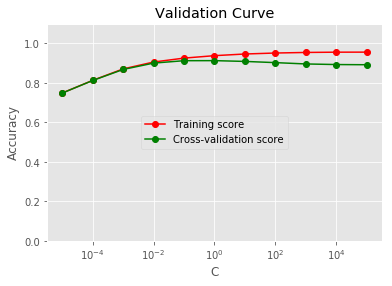

In [23]:
# Plot a validation curve across levels of C, using a logscale for the x axis
plot_validation_curve(train_scores_val, cv_scores_val, C_values, y_label='Accuracy', x_label='C', x_logscale=True)


**PROBLEM**: What was the best value of C?

In [24]:
# Obtain the best value of the hyper parameter
i=0
Best_accu=0
Best_c=0
for c in C_values:
    accu = np.mean(cv_scores_val[i])
    if accu > Best_accu:
        Best_c = c
        Best_accu = accu
    
    i+=1
print(Best_c)

1.0


**QUESTION**: Should we believe this particular "optimal" value of C. Why or why not? 

In [25]:
# View cross validation scores
i=0
for c in C_values:
    print("C = ", c, " accuracy:     ", end = '')
    print(np.mean(cv_scores_val[i]))
    i+=1

C =  1e-05  accuracy:     0.7484227744641355
C =  0.0001  accuracy:     0.8120241273344248
C =  0.001  accuracy:     0.8678572959454259
C =  0.01  accuracy:     0.8999403996491817
C =  0.1  accuracy:     0.9121425818902976
C =  1.0  accuracy:     0.9124403046008878
C =  10.0  accuracy:     0.9084822341386954
C =  100.0  accuracy:     0.9023809476533077
C =  1000.0  accuracy:     0.895684486895174
C =  10000.0  accuracy:     0.8926489558423502
C =  100000.0  accuracy:     0.8916965509164969


**Answer**:  

As we have done cross-validation, there is no reason to not believe the optimal value of C.

**QUESTION**: Comment on the performance of the Logit Model overall. Why did it (or did it not) perform well? Also comment on how regularization affected your results, and explain why regularization performed as it did. 

**Answer**: 

It does not perform extremly well because when we think about it, it does not really make sense to just take the value of a pixel into account, what really matters is the interaction of the pixels and there relation with neighbour pixels. This is why a CNN will be prefered. 

It does however performs decently but this is because all the training images are similarly centered so by "luck", encoding just the pixel as a feature is okay.

Regularization works quite well and we can think that it is the case because it will reduce the importance of some pixels (the ones on the side) which should not really be taken too much into account.


**QUESTION**: Would these results survive manipulation of the underlying picture (for example, randonly shifting pictures left/right or rotating them). 

**Answer**:  

No, the image is flattened into one single vector so if manipulation is done, absolutely every pixels will have offsets and the prediction might be completely wrong.


**PROBLEM**: What is the accuracy of the Logit Model on the test set at the best value of C?

In [31]:
# Calculate Accuracy of Logit Model on test set at best value of C
model_log_best = LogisticRegression(penalty='l2', n_jobs = -1, C=Best_c)

model_log_best = model_log_best.fit(X_train, y_train)
y_hat = model_log_best.predict(X_test)
accuracy_score(y_test, y_hat)


0.909047619047619

The accuracy on the test set with the Logit Model is 0.909

## KNN Classifier

**PROBLEM**: Repeat the exercise above with a KNN Classifier to predict labels. 
  * Use a stratified K-Fold cross-validation schema with 3 folds.
  * Tune hyperparameter K from K=5 to K=45, in 5 point increments. 
  * Make sure to use the random state SEED, and remember that KNN will be slow to run...
  * Use **`accuracy`** for the tuning score.
  * Use the `validation_curve()` function from sklearn to train and validate models across K.
  * Set `n_jobs` to -1 to use all available CPU cores on your computer.
  * Set the random seed.

In [33]:
# Use a KNN Classifier to predict labels
K_values  = np.array([int(i) for i in np.linspace(5.0, 45.0, 10)])
model_knn     = KNeighborsClassifier(n_jobs = -1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(
     
    model_knn, X_train, y_train, param_name="n_neighbors",
    param_range=K_values, cv=cv_schema

)

**PROBLEM**: Use the `validation_curve()` function to plot the Training and Cross-Validated results.

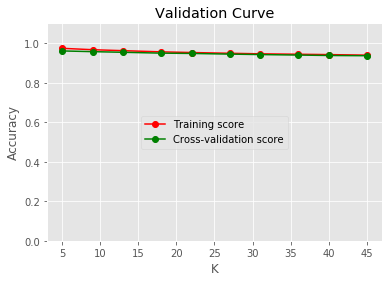

In [34]:
# Plot a validation curve across levels of K
plot_validation_curve(train_scores_val, cv_scores_val, K_values, y_label='Accuracy', x_label='K', x_logscale=False)



**QUESTION**: Comment on and explain your results from the KNN Model. 

**Answer**:  

Looking at the Validation Curve, it appears that the best K is 5. Both the training accuracy and the validation accuracy decrease as the model generalizes more with K increasing.



**PROBLEM**: What is the accuracy of the KNN Model on the test set at the best value of K?

In [35]:
# Calculate Accuracy of KNN Model on test set at best value of K
i=0
Best_accu=0
Best_k=0
for k in K_values:
    accu = np.mean(cv_scores_val[i])
    if accu > Best_accu:
        Best_k = k
        Best_accu = accu
    
    i+=1
print(Best_k)

model_knn_best = KNeighborsClassifier(n_jobs = -1, n_neighbors = Best_k)

model_knn_best = model_knn_best.fit(X_train, y_train)
y_hat = model_knn_best.predict(X_test)
accuracy_score(y_test, y_hat)

5


0.9672619047619048

The accuracy on the test set with the kNN Model is 0.967.

## Random Forest

**PROBLEM**: Repeat the exercise above with a Random Forest Classifier to predict labels. 
  * Use a stratified K-Fold cross-validation schema with 3 folds.
  * Tune hyperparameter K from K=5 to K=45, in 5 point increments. 
  * Make sure to use the random state SEED, and remember that KNN will be slow to run...
  * Use **`accuracy`** for the tuning score.
  * Use the `validation_curve()` function from sklearn to train and validate models across K.
  * Set `n_jobs` to -1 to use all available CPU cores on your computer.
  * Set the random seed.

In [36]:
# Use a Random Forest Classifier to predict labels
N_values  = np.array([int(i) for i in np.linspace(5.0, 45.0, 10)])
model_forest = RandomForestClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(

    model_forest, X_train, y_train, param_name="n_estimators",
    param_range=N_values, cv=cv_schema

)



**PROBLEM**: Use the `validation_curve()` function to plot the Training and Cross-Validated results.

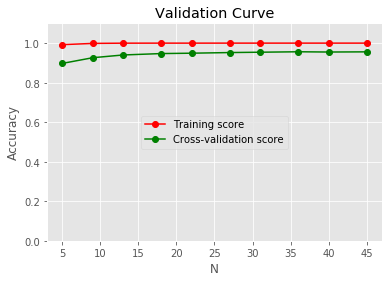

In [37]:
# Plot a validation curve across levels of N
plot_validation_curve(train_scores_val, cv_scores_val, N_values, y_label='Accuracy', x_label='N', x_logscale=False)



**QUESTION**: Comment on and explain your results from the Random Forest Model. 

**Answer**: 

The best number of estimators appears to be 45. 



**QUESTION**: Comment on the behavior of the Training accuracy and the Cross-Validation accuracy in the Random Forest model for this problem. Explain why you think they performed (relatively) as they did. 

In [38]:
# Do some inspections...

# View cross training scores
i=0
for n in N_values:
    print("N = ", n, " accuracy:     ", end = '')
    print(np.mean(train_scores_val[i]))
    i+=1
    

N =  5  accuracy:     0.9922321208464949
N =  9  accuracy:     0.9986160853637164
N =  13  accuracy:     0.9997470118484125
N =  18  accuracy:     0.9999255932443097
N =  22  accuracy:     0.9999255932443097
N =  27  accuracy:     1.0
N =  31  accuracy:     1.0
N =  36  accuracy:     1.0
N =  40  accuracy:     1.0
N =  45  accuracy:     0.9999851170543673


In [39]:
# Do some inspections...

# View cross validation scores
i=0
for n in N_values:
    print("N = ", n, " accuracy:     ", end = '')
    print(np.mean(cv_scores_val[i]))
    i+=1

N =  5  accuracy:     0.8974105579609661
N =  9  accuracy:     0.9261906081495611
N =  13  accuracy:     0.940089338628745
N =  18  accuracy:     0.9471724889726166
N =  22  accuracy:     0.949077394449159
N =  27  accuracy:     0.952291967289923
N =  31  accuracy:     0.9540178868055893
N =  36  accuracy:     0.9562798554754001
N =  40  accuracy:     0.9549704033215107
N =  45  accuracy:     0.9558930064807699


**Answer**: _____

The training set accuracy indicates that the random forest is extremly sensitive so what we observe is severe overfitting. The validation set accuracy is thus affected by the overfitting but increasing the number of estimators acts like regularization and induces more generalization in the validation set. ____

**PROBLEM**: What is the accuracy of the Random Forest Model on the test set at the best value of N Estimators?

In [42]:
# Obtain the best value of the hyper parameter
i=0
Best_accu=0
Best_n=0
for n in N_values:
    accu = np.mean(cv_scores_val[i])
    if accu > Best_accu:
        Best_n = n
        Best_accu = accu
    
    i+=1

model_forest_best = RandomForestClassifier(n_jobs = -1, n_estimators = Best_n) 
model_forest_best = model_forest_best.fit(X_train, y_train)
y_hat = model_forest_best.predict(X_test)
accuracy_score(y_test, y_hat)

0.9561904761904761

The accuracy on the test set with the Random Forest Model is 0.956.

# PART 3: Convolutional Neural Networks (CNN) 

**PROBLEM**: Prepare data for a CNN. 

In [201]:
# Reshape image into 3 dimensions where third dimension is only 1 deep (so: height = 28px, width = 28px , canal = 1)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_test_reshaped  = X_test.values.reshape(X_test.shape[0], 28, 28, 1)


In [202]:
# Encode target labels to one hot vectors
y_train_ohe = tf.keras.utils.to_categorical(y_train, 10)
y_test_ohe = tf.keras.utils.to_categorical(y_test, 10)

**PROBLEM**: Print the value of some pixels from the new, reshaped array to show you can access the data. 

In [203]:
# Print first pixel in first observation
print(X_train_reshaped[0][0][0])

[0.]


In [204]:
# Print last pixel in last observation
print(X_train_reshaped[-1][-1][0])

[0.]


In [205]:
# Print pixel from Observation 1234, horizontal offset 23, vertical offset 12
print(X_train_reshaped[23][12][0])

[0.]


**PROBLEM**: Make a custom function to build and return a CNN object from TensorFlow.Keras (version 2). 

In [216]:
# Custom function to build and return a cnn model from TensorFlow.Keras (version 2)
def cnn_model():
    model = tf.keras.Sequential()
    # Must define the input shape in the first layer of the neural network
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model


**PROBLEM**: Instantiate a model from your function above and print a diagram for it. 

In [208]:
# Instantiate a model from your function above and print a diagram for it.
cnn_model  = cnn_model()



**PROBLEM**: Fit the model for 10 epochs and a batch size of 200, and then print a summary. _Tip:_ Be sure to use the reshaped training data.

In [209]:
# Fit the model and print a summary 
cnn_model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = cnn_model.fit(X_train_reshaped, y_train_ohe, epochs=10, batch_size=200)
cnn_model.summary()

Train on 33600 samples
Epoch 1/10
33600/33600 [==============================] - 19s 558us/sample - loss: 0.4069 - accuracy: 0.8725
Epoch 2/10
33600/33600 [==============================] - 17s 495us/sample - loss: 0.1132 - accuracy: 0.9654
Epoch 3/10
33600/33600 [==============================] - 17s 502us/sample - loss: 0.0830 - accuracy: 0.9751
Epoch 4/10
33600/33600 [==============================] - 18s 525us/sample - loss: 0.0671 - accuracy: 0.9795
Epoch 5/10
33600/33600 [==============================] - 18s 542us/sample - loss: 0.0569 - accuracy: 0.9816
Epoch 6/10
33600/33600 [==============================] - 17s 517us/sample - loss: 0.0475 - accuracy: 0.9851
Epoch 7/10
33600/33600 [==============================] - 17s 518us/sample - loss: 0.0446 - accuracy: 0.9858
Epoch 8/10
33600/33600 [==============================] - 18s 530us/sample - loss: 0.0424 - accuracy: 0.9862
Epoch 9/10
33600/33600 [==============================] - 17s 514us/sample - loss: 0.0373 - accuracy: 0.9

**PROBLEM**: Evaluate the trained CNN model on the test set and print the loss score and accuracy score. 

In [210]:
# Evaluate trained model on test set
test_score = cnn_model.evaluate(X_test_reshaped, y_test_ohe, verbose=0)


In [211]:
# Print the loss and accuracy scores
print('\n', 'Test loss:', test_score[0])
print('\n', 'Test accuracy:', test_score[1])



 Test loss: 0.03999618888796595

 Test accuracy: 0.9886905


**PROBLEM**: Get the predicted values and identify the correct cases/incorrect cases. 

In [212]:
# Get predicted values
y_pred = cnn_model.predict_classes(X_test_reshaped)

correct=0
index_wrong_class = []
index_correct_class = []
for i in range(len(X_test_reshaped)):
    if y_pred[i] == y_test[i]:
        correct+=1
        index_correct_class.append(i)
    else:
        index_wrong_class.append(i)

**PROBLEM**: Print number of correctly and incorrectly clasified observations. 

In [213]:
# Print number of correctly and incorrectly clasified observations    
print('\n', 'correctly classified:', correct)
print('\n', 'Incorrectly classified:', len(X_test)-correct)


 correctly classified: 8305

 Incorrectly classified: 95


**PROBLEM**: Display 5 examples of incorrectly classified images. 

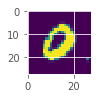

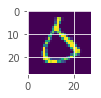

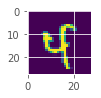

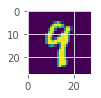

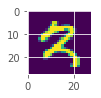

In [214]:
# Display the first 5 examples of incorrectly classified images
def transform_2D(vector):
    Matrix = [[0 for x in range(28)] for y in range(28)] 
    for i in range(28):
        for j in range(28):
            Matrix[i][j] = vector[28*i + j] 
    return Matrix

first_indexes = index_wrong_class[0:5]

for index in first_indexes:
    image = transform_2D(X_test.iloc[index])
    plt.subplot(3, 1, 1)
    plt.imshow(image)
    plt.show()




**QUESTION**: Explain why you think the CNN made an error on those observations. 

**Answer**: 

All these images are extremly confusing: the traces are either too large or too narrow. The second example here is 
very confusing because the zero has a sharp edge on top and this one could potentialy event trick a human. 
CNNs are very sensitive to edges so if a zero has one, the odds that is will be wrongly classified are big.


**PROBLEM**: Predict and then use the plot the custom `plot_confusion_matrix()` function to plot the confustion matrix for all ten digits. 

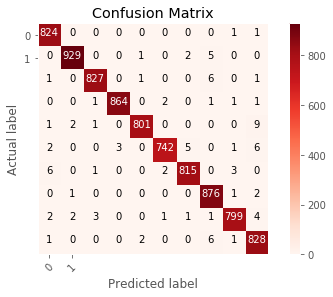

In [215]:
# Print the confustion matrix for all ten digits
cm = confusion_matrix(y_test, y_pred)  
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds)



# PART 4: Stress Your Data and Re-Run Models and Tests

This final part of this assignment is open-ended... Think of ways to distort, manipulate, and stress your training data. Take those steps and then re-run a Logit Model and a CNN model. Compare how the two models perform (relatively) given the stressed training data. Comment on what you find. This is worth 25% of the assignment, so be creative and thorough.

In [217]:
from keras.preprocessing.image import ImageDataGenerator 

# Save dataset sizes
train_size = X_train_reshaped.shape[0]
test_size = X_test_reshaped.shape[0]
      
augment_size=30000

image_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.05, 
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False,
    vertical_flip=False, 
    data_format="channels_last",
    zca_whitening=True)


image_generator.fit(X_train_reshaped, augment=True)
# get transformed images
randidx = np.random.randint(train_size, size=augment_size)
x_augmented = X_train_reshaped[randidx].copy()
y_augmented = y_train_ohe[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                            batch_size=augment_size, shuffle=False).next()[0]
        
# append augmented data to trainset
X_train_reshaped = np.concatenate((X_train_reshaped, x_augmented))
y_train_ohe = np.concatenate((y_train_ohe, y_augmented))
train_size = X_train_reshaped.shape[0]
test_size = X_test_reshaped.shape[0]

def next_train_batch(batch_size):
    randidx = np.random.randint(self.train_size, size=batch_size)
    epoch_x = self.x_train[randidx]
    epoch_y = self.y_train[randidx]
    return epoch_x, epoch_y

def next_test_batch(batch_size):
    randidx = np.random.randint(self.test_size, size=batch_size)
    epoch_x = self.x_test[randidx]
    epoch_y = self.y_test[randidx]
    return epoch_x, epoch_y

def shuffle_train():
    indices = np.random.permutation(self.train_size)
    self.x_train = self.x_train[indices]
    self.y_train = self.y_train[indices]

In [218]:
#Verify that 10000 new images have been appended
print(len(X_train_reshaped))
print(len(X_test_reshaped))

63600
8400


In [219]:
cnn_model_aug  = cnn_model()
cnn_model_aug.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
history = cnn_model_aug.fit(X_train_reshaped, y_train_ohe, epochs=10, batch_size=200)
cnn_model_aug.summary()

Train on 63600 samples
Epoch 1/10
63600/63600 [==============================] - 32s 507us/sample - loss: 0.4389 - accuracy: 0.8650
Epoch 2/10
63600/63600 [==============================] - 33s 523us/sample - loss: 0.1335 - accuracy: 0.9605
Epoch 3/10
63600/63600 [==============================] - 32s 505us/sample - loss: 0.0967 - accuracy: 0.9720
Epoch 4/10
63600/63600 [==============================] - 34s 540us/sample - loss: 0.0782 - accuracy: 0.9765
Epoch 5/10
63600/63600 [==============================] - 34s 535us/sample - loss: 0.0655 - accuracy: 0.9794
Epoch 6/10
63600/63600 [==============================] - 32s 496us/sample - loss: 0.0544 - accuracy: 0.9829
Epoch 7/10
63600/63600 [==============================] - 32s 496us/sample - loss: 0.0514 - accuracy: 0.9842
Epoch 8/10
63600/63600 [==============================] - 32s 505us/sample - loss: 0.0449 - accuracy: 0.9853
Epoch 9/10
63600/63600 [==============================] - 33s 514us/sample - loss: 0.0441 - accuracy: 0.9

In [220]:
#Evaluation of the test score
test_score = cnn_model_aug.evaluate(X_test_reshaped, y_test_ohe, verbose=0)
# Print the loss and accuracy scores
print('\n', 'Test loss:', test_score[0])
print('\n', 'Test accuracy:', test_score[1])



 Test loss: 0.03611885030587603

 Test accuracy: 0.9892857


Comment: 

By distorting and stressing the data, we can artificialy add new images (30000) to the dataset and thus increase the prediction of the CNN.

For this part, the library keras was used to get the function ImageDataGenerator() which was used to
create new "stressed" images similar to some images of the training set but with some random rotation, zoom, width shift and height shift.

As a result, for the same amount of epochs, the accuracy with the augmented data is 0.9892 > 0.9886.
The augmentation allowed to improve the model to be able to predict correctly a couple more images on the test set.